## Mapping Workloads to Architectures
This notebook shows how to run the Fast & Fusiest Mapper (FFM) to map a workload onto an
architecture.

We first initialize the spec. The spec is initialized with a `af.Spec` object
using YAML files (though you may also initialize them with Python objects).

When loading specifications, Jinja2 templating can be used, and the `jinja_parse_data`
parameter can be used to pass in data to the templating engine.

In [1]:
from pathlib import Path

examples_dir = Path("../../examples")

# < DOC_INCLUDE_MARKER > make_spec
import accelforge as af

# Set the number of parallel threads that the mapper can use. If you are running out of
# memory, you may decrease this number. By default the number of threads is set to the
# number of cores on your machine.
import os
af.set_n_parallel_jobs(os.cpu_count(), print_message=True)

# Initialize the spec and show the workload.
BATCH_SIZE = 1
N_TOKENS = 16384
FUSE = True
spec = af.Spec.from_yaml(
    examples_dir / "arches" / "tpu_v4i.yaml",
    examples_dir / "workloads" / "gpt3_6.7B.yaml",
)
# Fusion happens when tensors bypass the outermost Memory object, so, to disable fusion,
# force all tensors to be in the outermost memory.
if not FUSE:
    for node in spec.arch.nodes:
        if isinstance(node, af.arch.Memory):
            print(f'Keeping all tensors in {node.name}')
            node.tensors.keep = "All"
            break

WARNING Loading configuration file from /home/tanner/.config/accelforge/config.yaml


Using 32 parallel jobs


Now we'll visualize the workload. The workload is a cascade of Einsums, with boxes
showing Einsums (computation steps), ovals showing tensors, and arrows showing
dependencies.

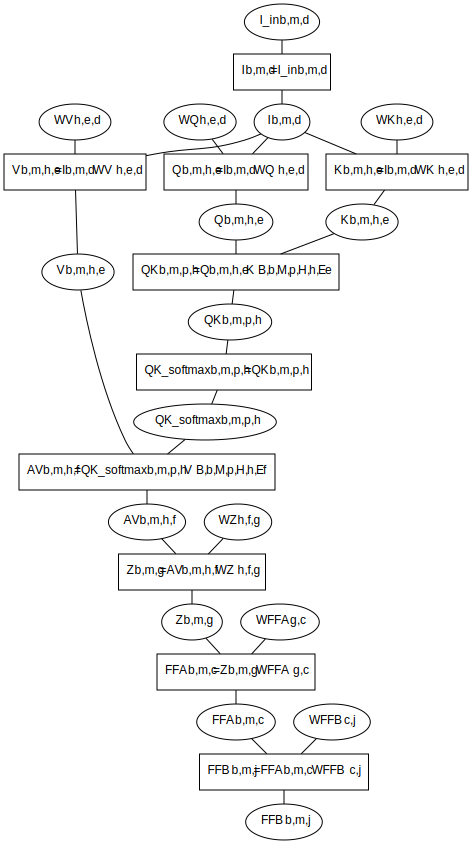

In [2]:
spec.workload

Next, we'll set optimization metrics for the mapper. Note that having fewer metrics is
faster, because it makes it easier to prune suboptimal mappings. A mapping is suboptimal
if and only if another mapping is better in all metrics.

In [3]:
# Set optimization metrics
spec.mapper.ffm.metrics = af.mapper.FFM.Metrics.ENERGY
# spec.mapper.ffm.metrics = af.mapper.FFM.Metrics.LATENCY
# spec.mapper.ffm.metrics = af.mapper.FFM.Metrics.LATENCY | af.mapper.FFM.Metrics.ENERGY

Workloads can be mapped onto the architecture in one step using the `af.mapper.FFM.map_workload_to_arch` function.

In [4]:
# < DOC_INCLUDE_MARKER > map_workload_to_arch

# Commenting this will be slower, but may generate better mappings. Limits the number of
# fused loops that can exist in a single pmapping.


# NOTE: We get different bugs whether max_fused_loops is 0 or 1.
spec.mapper.ffm.max_fused_loops = 1
mapping = af.mapper.FFM.map_workload_to_arch(spec)
# pmappings = af.mapper.FFM.make_pmappings(spec)
# joined = af.mapper.FFM.join_pmappings(pmappings)

Getting energy, latency, and leak power for components running FFB: 100%|██████████| 10/10 [00:00<00:00, 19.00it/s]      
Generating pmapping templates for compute ScalarUnit Einsum I: 2it [00:00, 36.79it/s]it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]0, 97.80it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for co

Not tracking memory MainMemory. It is big enough to hold every workload tensor that may be stored in it. Max possible usage: 0.00%
Not tracking memory Register across joining stages. It is never reserved across fused loop iterations.
Not tracking memory LocalBuffer across joining stages. It is never reserved across fused loop iterations.


Grouping pmappings for FFB: 100%|██████████| 9/9 [00:00<00:00, 67.61it/s]


V: 1.27e12 total, 2.75e09 (1/461) valid, 7.47e06 (1/1.70e05) evaluated, 3.00e04 (1/4.23e07) Pareto-Optimal
Z: 1.27e12 total, 2.34e09 (1/543) valid, 5.85e06 (1/2.17e05) evaluated, 1.82e04 (1/6.99e07) Pareto-Optimal
Q: 1.27e12 total, 6.81e08 (1/1.86e03) valid, 7.47e06 (1/1.70e05) evaluated, 3.00e04 (1/4.23e07) Pareto-Optimal
K: 1.27e12 total, 2.36e09 (1/539) valid, 7.47e06 (1/1.70e05) evaluated, 3.00e04 (1/4.23e07) Pareto-Optimal
QK: 1.18e12 total, 1.21e07 (1/9.80e04) valid, 3.97e06 (1/2.98e05) evaluated, 2.62e04 (1/4.52e07) Pareto-Optimal
AV: 1.18e12 total, 4.49e07 (1/2.64e04) valid, 1.04e07 (1/1.14e05) evaluated, 2.36e04 (1/5.02e07) Pareto-Optimal
FFA: 1.07e11 total, 1.87e08 (1/574) valid, 4.19e06 (1/2.56e04) evaluated, 1.12e04 (1/9.61e06) Pareto-Optimal
QK_softmax: 3.25e06 total, 2 (1/1.62e06) valid, 4.38e03 (1/742) evaluated, 157 (1/2.07e04) Pareto-Optimal
I: 9.74e03 total, 75 (1/130) valid, 159 (1/61) evaluated, 70 (1/139) Pareto-Optimal
FFB: 4.30e10 total, 5.52e07 (1/778) valid, 2.

Joining pmappings for FFA <--> FFB (10/10): 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]
/home/tanner/research/fusion/fastfusion/fastfusion/accelforge/mapper/FFM/_join_pmappings/join_pmappings.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joined._data = joined.data.fillna(0).reset_index(drop=True)


RuntimeError: 'c' not found in {'AV': {('B', 'b'): (1, 0), ('M', 'm'): (1, 0), ('H', 'h'): (1, 0), ('F', 'f'): (1, 0)}, 'Z': {('B', 'b'): (1, 0), ('M', 'm'): (1, 0), ('G', 'g'): (1, 0)}, 'WZ': {('H', 'h'): (1, 0), ('F', 'f'): (1, 0), ('G', 'g'): (1, 0)}} for einsum Z

<!-- < DOC_INCLUDE_MARKER > FFM_parts -->

The mapper consists of two parts:

- The Turbo-Charged Pmapper: This part makes all Pareto-optimal pmappings for all
  Einsums.
- Fast and Fusiest: This part takes the Pareto-optimal pmappings and joins them into
  full mappings.

Mapping begins with the Turbo-Charged Pmapper with the `make_pmappings` function.

In [ ]:
# < DOC_INCLUDE_MARKER > make_pmappings

# Commenting this will be slower, but may generate better mappings. Limits the number of
# fused loops that can exist in a single pmapping.
spec.mapper.ffm.max_fused_loops = 1

pmappings = af.mapper.FFM.make_pmappings(
    spec,
    # Having can_combine_multiple_runs=False is faster, so it should generally be set to
    # True. If it is set to False, then you may run make_pmappings multiple times with
    # compatible specs and combine them:
    #   pmappings = make_pmappings(*args_a) | make_pmappings(*args_b)
    can_combine_multiple_runs=False
)


In [ ]:
# < DOC_INCLUDE_MARKER > pmappings_stats

# Output some stats about the generated pmappings.
print(f"Total number of pmappings: {pmappings.n_total_pmappings()}")
print(f"Number of valid pmappings: {pmappings.n_valid_pmappings()}")
print(f"Number of Pareto-optimal pmappings: {pmappings.n_pareto_optimal_pmappings()}")
print(f"Number of evaluated pmappings: {pmappings.n_evaluated_pmappings()}")

In [ ]:
# < DOC_INCLUDE_MARKER > join_pmappings

# Join the pmappings to create a full mapping.
mappings = af.mapper.FFM.join_pmappings(spec,pmappings)

In [ ]:
# The joined pmappings object contains a DataFrame of all Pareto-optimal pmappings for
# the given optimization metrics. Since we're only interested in one metric, this should
# have exaclty one row, but we'll grab index 0 to be sure.
mapping = mappings[0]

# All units are SI units-- seconds, joules, meters, etc.
print(f"Totals:")

# The access method accesses all columns that include Total.
for k, v in mapping.access("Total").to_dict().items():
    print(f"\t{k}: {v}")

In [ ]:
# Show the mapping.
mapping

In [ ]:
accessor = "latency" if spec.mapper.ffm.metrics == af.mapper.FFM.Metrics.LATENCY else "energy"
per_compute = mapping.access("Total").per_compute().to_dict()[accessor]
print(f'Per-compute {accessor}: {per_compute}')

print(f'Contributors to {accessor}:')
for k, v in mapping.access(accessor).to_dict().items():
    print(f"\t{k}: {v}")

# Print the other stats
for k, v in mapping.to_dict().items():
    print(f"{k}: {v}")